# make_UNet_training_set_smartspim

The purpose of this notebook is to illustrate how to make an example training/validation/test set for the 3D UNet. The training set consists of small (~300x300x75) volume subchunks of microscope images along with labeled volumes corresponding to each of those images. These labeled volumes are binary 3d arrays where 1 means there is a cell there. In this notebook we go through how to create these labeled volumes using <a href="https://en.wikipedia.org/wiki/Otsu%27s_method">Otsu thresholding</a>. 

To run this notebook, first download the CNN Demo dataset:   https://lightsheetatlas.pni.princeton.edu/public/brainpipe_demo_datasets/CNN_jupyter_demo.tar.gz

Unpack that file in a directory like:
```
tar -zxvf CNN_jupyter_demo.tar.gz
```
It should unpack into 6 files

## General imports

In [3]:
import os,sys, glob, shutil, pickle
import numpy as np
from skimage import filters
import matplotlib.pyplot as plt
import tifffile
import pandas as pd
%matplotlib inline

## Load in points and overlay on subvolume
The starting point for making the training set is having a list of coordinates representing in this example cell nuclei. These coordinates were extracted from ~300x300x75 pixel subvolumes. These subvolumes are also necessary for creating the training set. In this example, we have 3 subvolumes total, so 3 pairs of coordinate lists and their associated subvolumes.  

In [42]:
data_dir = "/jukebox/wang/ahoag/test_cnn_brainpipe_forpub/test_data"

In [41]:
sorted(glob.glob(data_dir+'/*')) 

['/jukebox/wang/ahoag/test_cnn_brainpipe_forpub/test_data/CNN_jupyter_demo.tar.gz',
 '/jukebox/wang/ahoag/test_cnn_brainpipe_forpub/test_data/annotations_subvol_x1111_y2778_z2500.npy',
 '/jukebox/wang/ahoag/test_cnn_brainpipe_forpub/test_data/annotations_subvol_x1400_y4500_z1150.npy',
 '/jukebox/wang/ahoag/test_cnn_brainpipe_forpub/test_data/annotations_subvol_x4444_y1667_z1500.npy',
 '/jukebox/wang/ahoag/test_cnn_brainpipe_forpub/test_data/subvol_x1111_y2778_z2500_img_reshaped.tif',
 '/jukebox/wang/ahoag/test_cnn_brainpipe_forpub/test_data/subvol_x1400_y4500_z1150_img_reshaped.tif',
 '/jukebox/wang/ahoag/test_cnn_brainpipe_forpub/test_data/subvol_x4444_y1667_z1500_img_reshaped.tif']

As we can see there are 3 tif files and 3 npy files. The tif files are the subvolumes and the npy files contain the coordinates. The absolute coordinates of the subvolume within the larger volume (not present) are contained in each filename, e.g.: subvol_**x1111_y2778_z2500**_img_reshaped.tif means that this volume starts at the voxel x=1111,y=2778,z=2500 in the larger volume. The npy files are linked to the subvolumes by these coordinates.

Let's load one of these pairs and overlay the points on the volume to verify that they look good. 

In [43]:
subvol1_file = os.path.join(data_dir,'subvol_x1111_y2778_z2500_img_reshaped.tif')
subvol1 = tifffile.imread(subvol_file)

In [23]:
subvol1.shape # z,y,x order due to how images are stored in numpy arrays

(75, 278, 278)

In [44]:
coords_subvol1_file = os.path.join(data_dir,'annotations_subvol_x1111_y2778_z2500.npy')
coords_subvol1_abs = np.load(coords_subvol1_file) # x,y,z order
coords_subvol1_abs[0:10]

array([[1298, 2843, 2505],
       [1137, 2964, 2504],
       [1183, 2976, 2505],
       [1173, 2825, 2504],
       [1318, 2975, 2505],
       [1181, 3005, 2506],
       [1218, 2950, 2510],
       [1138, 3014, 2511],
       [1236, 2875, 2509],
       [1375, 2847, 2510]])

These are the first 10 x,y,z coordinates of the points in this volume. Note that these are absolute coordinates. If we want to display them on top of the subvolume, we need to get them in coordinates relative to the zero of the subvolume.

In [45]:
x_start, y_start, z_start = 1111, 2778, 2500
coords_subvol1_rel = coords_subvol1_abs-(x_start,y_start,z_start) # coordinates relative to the origin of the subvolume
coords_subvol1_rel[0:10]

array([[187,  65,   5],
       [ 26, 186,   4],
       [ 72, 198,   5],
       [ 62,  47,   4],
       [207, 197,   5],
       [ 70, 227,   6],
       [107, 172,  10],
       [ 27, 236,  11],
       [125,  97,   9],
       [264,  69,  10]])

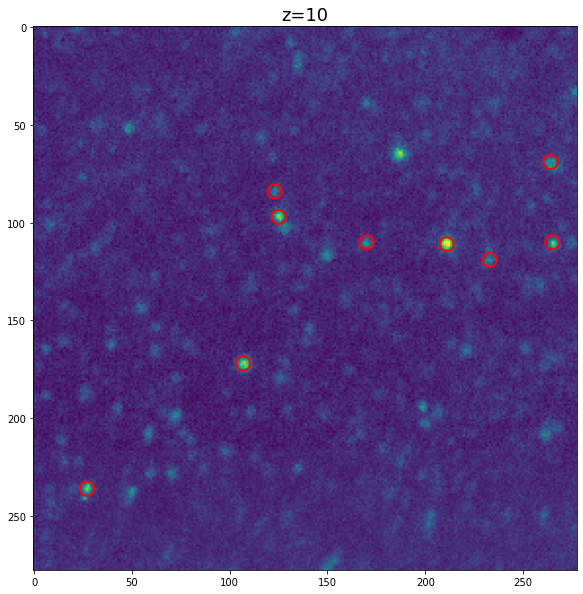

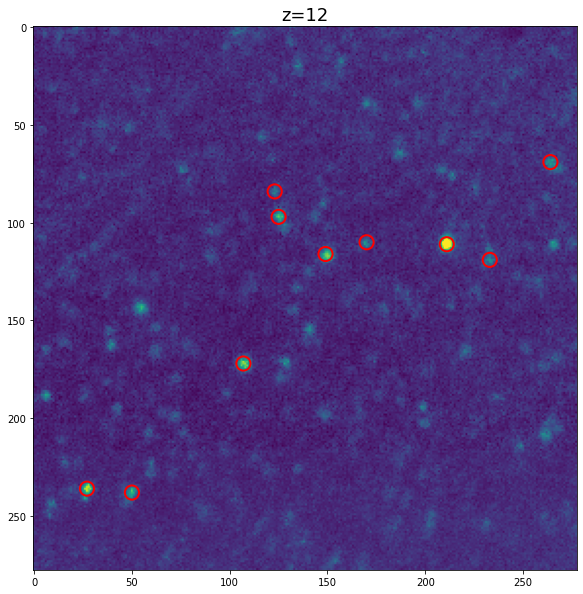

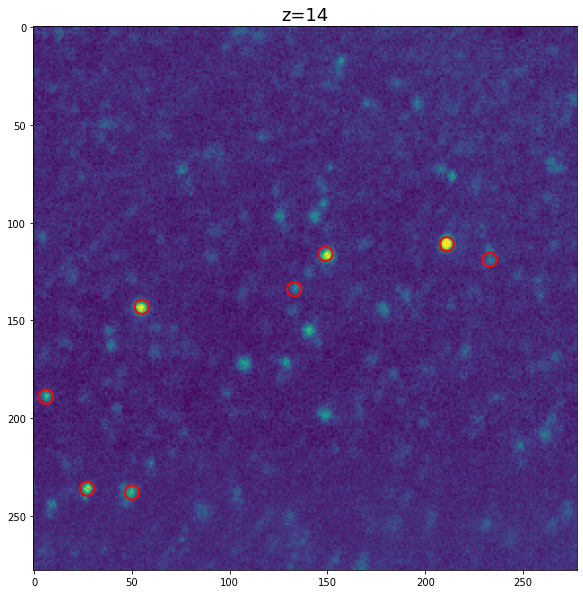

In [46]:
# Visually validate that annotations line up with real cell nuclei in this subvolume for a few different z planes
point_depth = 6 # the number of planes over we collapse in z to show image and labels.
# Chosen because most cells extend over this many planes

for z in [10,12,14]:
    zmin=int(np.max([z-point_depth/2.,0]))
    zmax=int(np.min([z+point_depth/2.,75]))
    mean_proj = np.mean(subvol1[zmin:zmax,:,:],axis=0)

    coords_subvol1_rel_depth = np.array([point for point in coords_subvol1_rel if zmin <= point[-1] < zmax])
    xs_depth = coords_subvol1_rel_depth[:,0]
    ys_depth = coords_subvol1_rel_depth[:,1]

    fig = plt.figure(figsize=(15,10))
    ax=fig.add_subplot(111)
    ax.imshow(mean_proj,vmin=0,vmax=200)

    ax.scatter(xs_depth,ys_depth,
               color="none",edgecolor='r',
               marker='o',s=200,
              linewidth=2)
    ax.set_title(f"z={z}",fontsize=18)

## Make the labeled subvolumes
The labels for the 3D U-Net CNN are not coordinates. Instead, they are volumes of the same dimensions as the image subvolumes but with a value of 1 where there is a cell and 0 where there is not. In our case, cells are smaller than the resolution of our microscope, so the PSF of the microscope determines the physical extent of the cell in most cases. This is still not a single voxel, so we need to use dilation to obtain the 3D voxel space for each cell. 

In [50]:
def make_labeled_subvol(subvolume,points):
    """ 
    ---PURPOSE---
    Takes a 3d array and a list of cell centers
    and creates a 3d array of the same shape
    that contains a binary mask where the 3d-extended
    cells are labeled = 1 in the mask
    ---INPUT---
    subvolume    A 3d array representing a chunk of volume
    points       A 2d array of coordinates relative to the origin of the subvolume, like:
        array([[187,  65,   5],
               [ 26, 186,   4],
               [ 72, 198,   5],
               ...,
               [233, 152,  43]])
    """
    size=(5,5,5) # (x,y,z) the half-size of the volume around each point that is used to make a cutout
    
    outarr = np.zeros_like(subvolume)
    otsu_factor=0.8 # a normalization factor for the filter threshold. Higher results in larger cell extent.
    for pnt in points:
        x_min=np.max((pnt[0]-size[0],0))
        x_max = pnt[0]+size[0]
        y_min = np.max((pnt[1]-size[1],0))
        y_max = pnt[1]+size[1]
        z_min = np.max((pnt[2]-size[2],0))
        z_max = pnt[2]+size[2]
        vol = np.copy(subvolume[z_min:z_max, y_min:y_max, x_min:x_max])*1.0
        vol = filters.gaussian(vol, sigma = 1)
        v=filters.threshold_otsu(vol)/float(otsu_factor)
        vol[vol<v]=0
        vol[vol>=v]=1
        newvol = np.maximum(outarr[z_min:z_max, y_min:y_max, x_min:x_max], vol)
        outarr[z_min:z_max, y_min:y_max, x_min:x_max]=newvol
    return outarr

In [51]:
# Note that we use the cell center coordinates relative to the subvolume origin (points1_rel)
# and not the ones relative to the entire brain origin (points1_abs)
lbl_subvol1 = make_labeled_subvol(subvolume=subvol1,
                                 points=coords_subvol1_rel) 

In [53]:
# Make sure the label array and origin volume have the same dimensions 
assert lbl_subvol1.shape == subvol1.shape

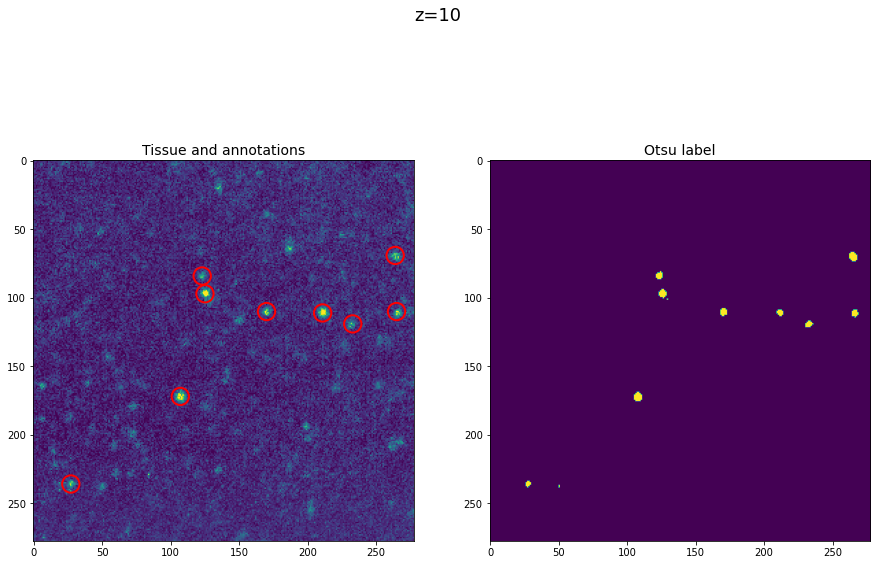

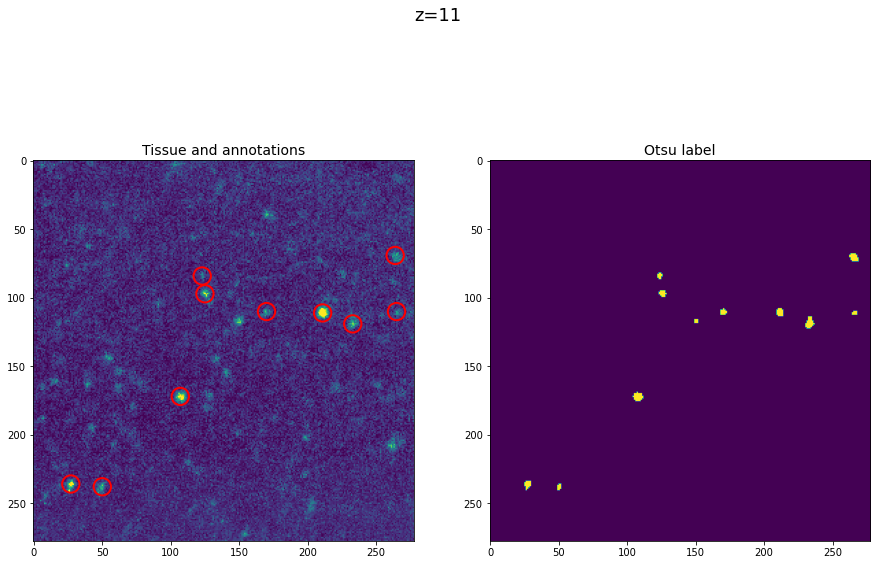

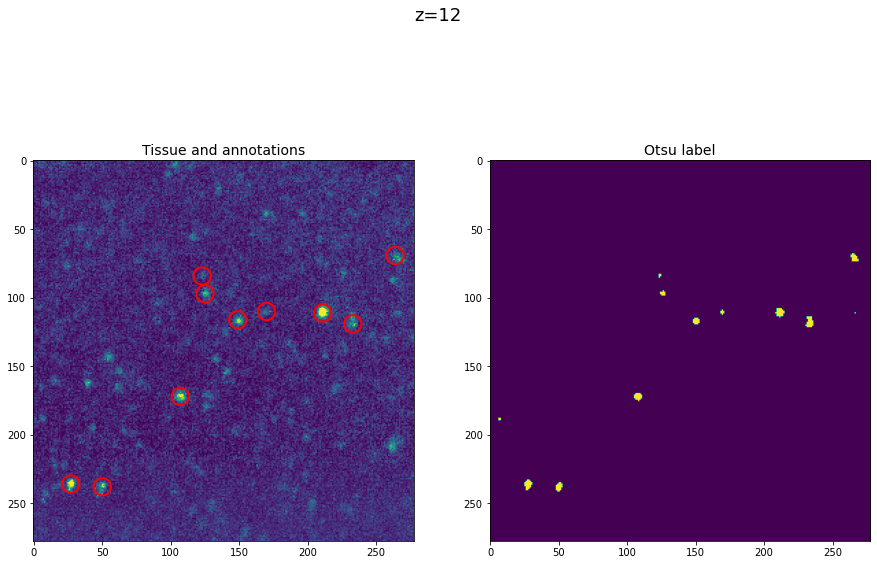

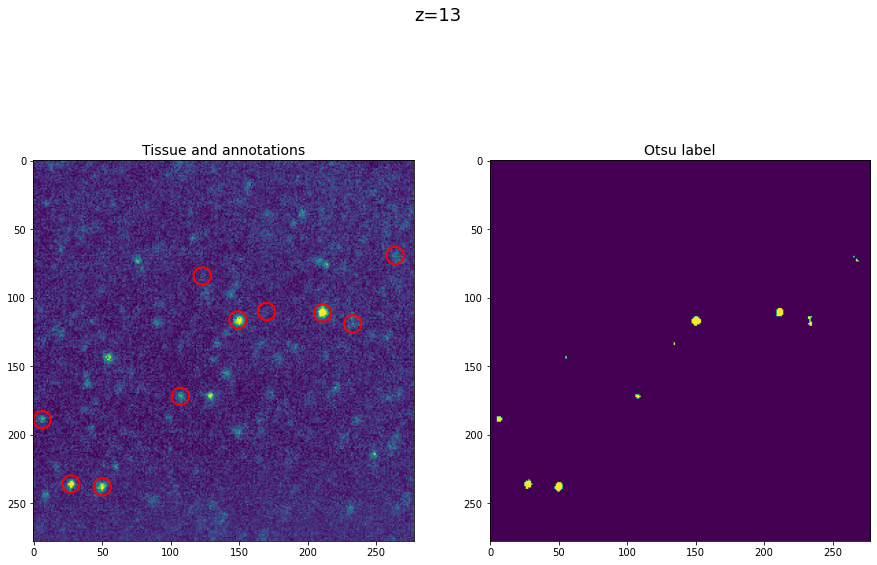

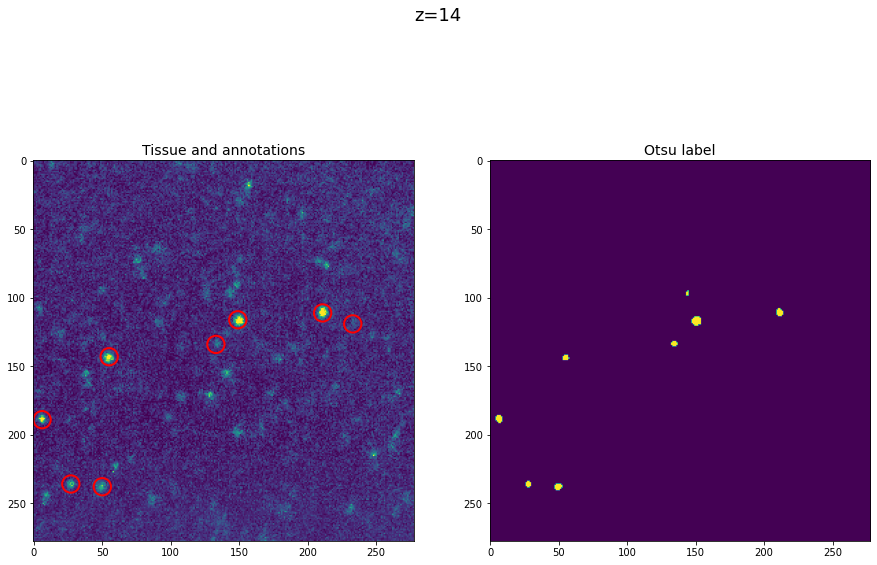

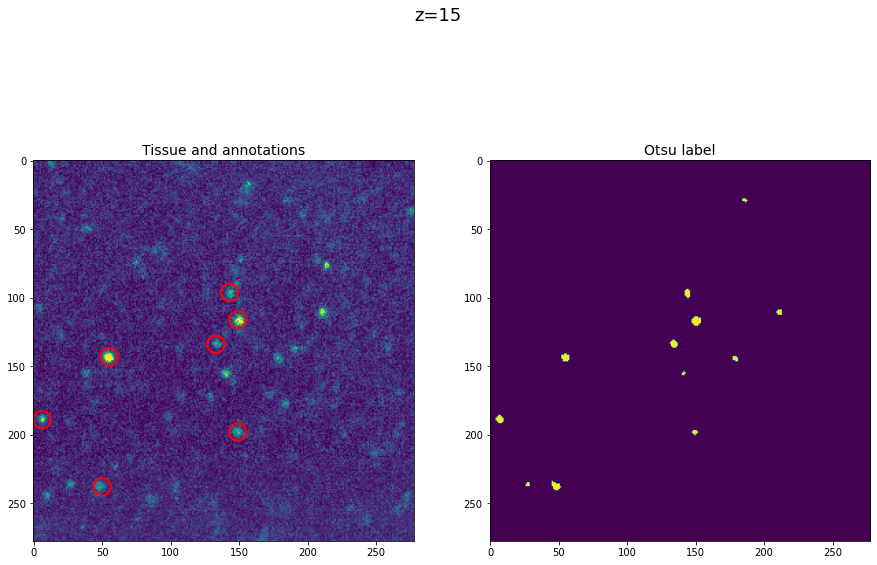

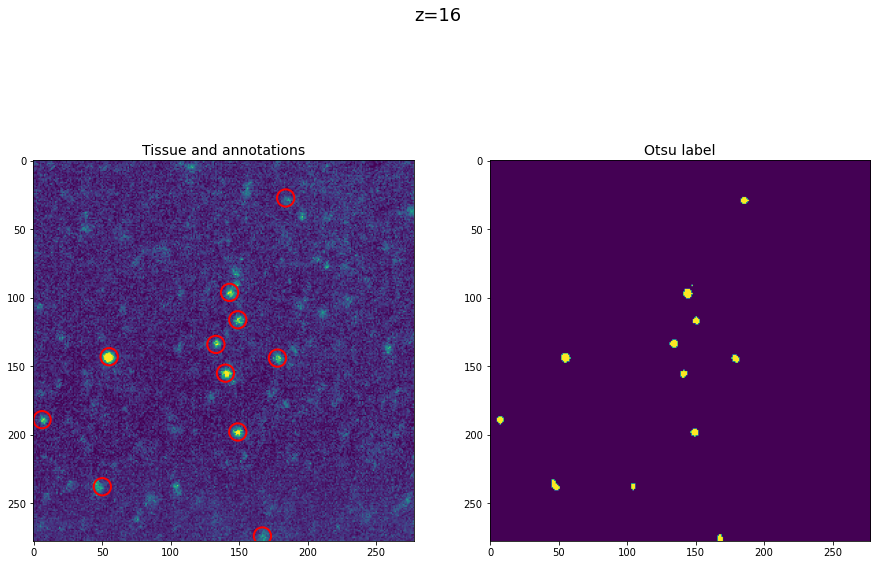

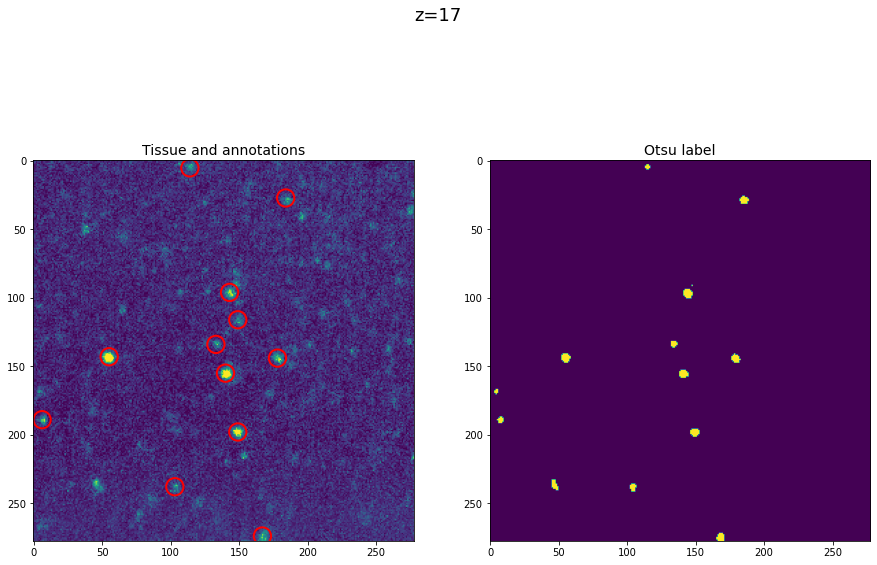

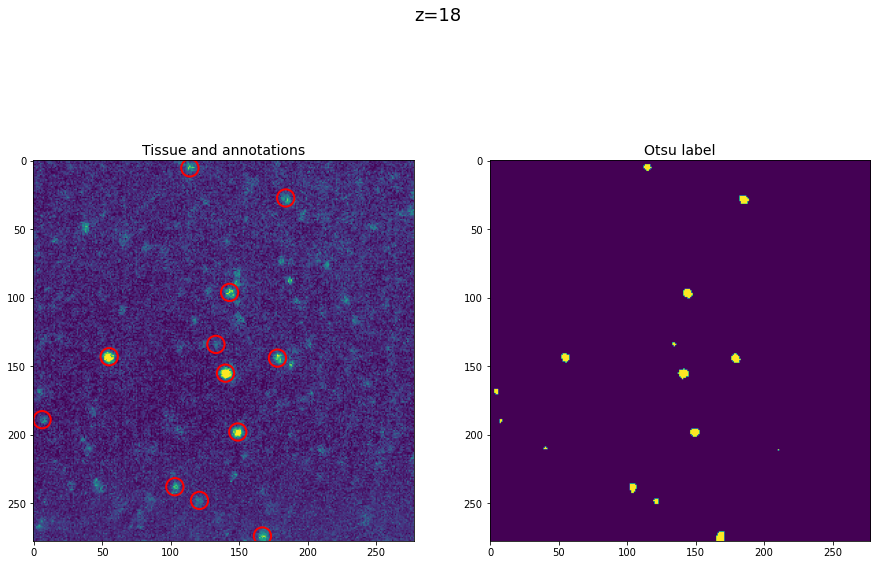

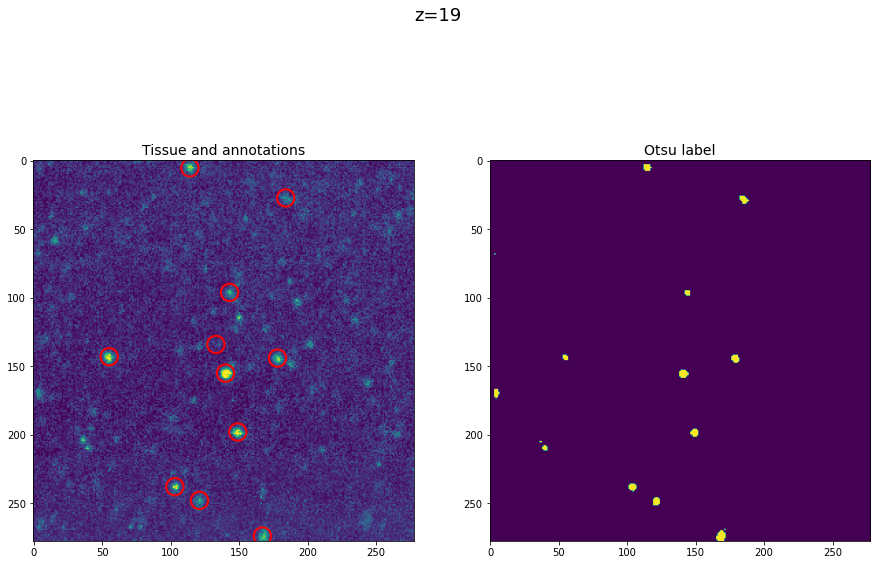

In [60]:
# Now check that the dilation gives a reasonable result.

point_depth = 6 # the number of planes over we collapse in z to show image and labels. Chosen because most cells extend this many planes
fontsize=14
for z in range(10,20):
    zmin=int(np.max([z-point_depth/2.,0]))
    zmax=int(np.min([z+point_depth/2.,75]))
#     mean_proj = np.mean(ws.source('stitched')[:,:,zmin:zmax],axis=2)

    coords_subvol1_rel_depth = np.array([point for point in coords_subvol1_rel if zmin <= point[-1] < zmax])
    xs_depth = coords_subvol1_rel_depth[:,0]
    ys_depth = coords_subvol1_rel_depth[:,1]

    fig = plt.figure(figsize=(15,10))
    fig.suptitle(f"z={z}",fontsize=18)
    ax_tiss=fig.add_subplot(121)
    subvol_thisplane = subvol1[z,:,:]
    ax_tiss.imshow(subvol_thisplane,vmin=0,vmax=200)

    ax_tiss.scatter(xs_depth,ys_depth,
               color="none",edgecolor='r',
               marker='o',s=300,
              linewidth=2)
    ax_tiss.set_title("Tissue and annotations",fontsize=fontsize)
    
    ax_lbl=fig.add_subplot(122)
    lbl_subvol_thisplane = lbl_subvol1[z,:,:]
    ax_lbl.imshow(lbl_subvol_thisplane,vmin=0,vmax=1)
    ax_lbl.set_title("Otsu label",fontsize=fontsize)
    


This is a reasonable result. The red circles in the left panel are the locations of the manually annotated cell coordinates within +/- 3 z planes of the current plane. These annotations were fed to the Otsu filter which dilated the coordinates to match the image. The Otsu labeling on the right captures the locations and approximate 3D shapes of each cell.  

If you find on your own data that there is too much speckling in the Otsu images, then try increasing the ostu_factor and/or increasing the sigma of the gaussian filter that is applied before the Otsu filter is applied. If the labels in the Otsu image look too smooth, then decrease the otsu_factor and/or decrease the sigma of the gaussian filter. 

# Save the otsu label as tif files.

Make sure to keep the subvolume coordinates in the filenames so they can be linked up when training the net.

In [ ]:
# for this single subvolume: 
savefile_lbl = 'subvol_x1111_y2778_z2500_lbl.tif'
tifffile.imsave(savefile_lbl,lbl_subvol1)

Do this for all subvolumes in your dataset to assemble your training set. 